In [1]:
# ========================================
# CELL 1: Install Dependencies
# ========================================
print("📦 Installing required packages...")

!pip install -q torch torchvision
!pip install -q mediapipe
!pip install -q opencv-python-headless
!pip install -q Pillow
!pip install -q matplotlib
!pip install -q git+https://github.com/FacePerceiver/facer.git@main

print("✅ All packages installed!")

📦 Installing required packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 12.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-

In [2]:
# ========================================
# CELL 2: Import Libraries
# ========================================
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import files
import io

print("✅ Libraries imported successfully!")

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


✅ Libraries imported successfully!


In [3]:
# ========================================
# CELL 3: Define ResNet-34 Model Architecture
# ========================================
print("🏗️ Defining ResNet-34 architecture...")

# Load pre-trained ResNet-34
model = models.resnet34(pretrained=False)

# Replace final layer for 4-class classification
model.fc = nn.Linear(model.fc.in_features, 4)

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"✅ Model architecture defined!")
print(f"🔧 Using device: {device}")


🏗️ Defining ResNet-34 architecture...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model architecture defined!
🔧 Using device: cuda


In [5]:
# ========================================
# CELL 3: Define DenseNet-121 Model Architecture
# ========================================
print("🏗️ Defining DenseNet-121 architecture...")

# Load pre-trained DenseNet-121
model = models.densenet121(pretrained=False)

# Replace final layer for 4-class classification
# DenseNet's classifier is a linear layer named 'classifier'
model.classifier = nn.Linear(model.classifier.in_features, 4)

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"✅ Model architecture defined!")
print(f"🔧 Using device: {device}")

🏗️ Defining DenseNet-121 architecture...
✅ Model architecture defined!
🔧 Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [38]:
# ========================================
# CELL 5: FACER-BASED PRECISE FACE + HAIR CROP (FIXED - EXCLUDE CLASS 3)
# ========================================
# FINAL VERSION: Include face + facial parts (4-13) + hair
# EXCLUDE: Class 3 (shoulders/body), Class 15+ (outfit/neck)
# ========================================

print("🎭 Defining precise face + hair crop using Facer (FIXED)...")

def create_face_crop_facer_style(image_path):
    """
    Crop ONLY face + hair using Facer toolbox for precise boundaries.
    Cut at chin level - NO neck, NO body, NO shoulders, NO outfit.

    FIXED CLASS INDICES (BASED ON DIAGNOSTICS FOR THIS IMAGE):
    - Class 1 = Face (User Feedback)
    - Class 2 = Included based on user feedback
    - Class 4 = Included based on user feedback
    - Classes 3, 5, 6, 7, 8, 9, 10, 12, 13 = Facial parts
    - Class 14 = Hair
    - EXCLUDE: Class 0 (background), 11, 15+ (outfit/neck/body)

    Args:
        image_path: Path to input image

    Returns:
        cropped_face: PIL Image (face + hair, 224x224)
        original_image: Original PIL Image
        mask: Binary mask for face region
    """
    print("🎭 Creating precise face + hair crop using Facer...")

    # Import facer
    import facer

    # Read image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = image_rgb.shape

    # Convert to PIL for reference
    pil_image = Image.fromarray(image_rgb)

    # ========== SETUP DEVICE ==========
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"   - Using device: {device}")

    # ========== PREPARE IMAGE FOR FACER ==========
    print("   - Preparing image...")
    # IMPORTANT: Use uint8 NOT float32!
    image_tensor = torch.tensor(image_rgb, dtype=torch.uint8).permute(2, 0, 1).unsqueeze(0).to(device)

    # ========== FACE DETECTION ==========
    print("   - Detecting faces with RetinaFace...")
    try:
        face_detector = facer.face_detector('retinaface/mobilenet', device=device)
    except:
        face_detector = facer.face_detector('retinaface/resnet50', device=device)


    with torch.inference_mode():
        batch_dicts = face_detector(image_tensor)

    # ========== CHECK IF FACES DETECTED ==========
    if not batch_dicts or len(batch_dicts) == 0:
        print("⚠️ No faces detected!")
        return pil_image, pil_image, np.ones((image_height, image_width), dtype=np.uint8) * 255

    batch_dict = batch_dicts[0] if isinstance(batch_dicts, list) else batch_dicts
    print("   - Face(s) detected")


    # ========== FACE PARSING (SEGMENTATION) ==========
    print("   - Parsing face (hair/face segmentation)...")
    try:
        face_parser = facer.face_parser('farl/celebm/448', device=device)
    except:
        try:
            face_parser = facer.face_parser('farl/lapa/448', device=device)
        except:
            print("⚠️ Face parser loading failed!")
            return pil_image, pil_image, np.ones((image_height, image_width), dtype=np.uint8) * 255


    with torch.inference_mode():
        batch_dicts = face_parser(image_tensor, batch_dicts)

    batch_dict = batch_dicts[0] if isinstance(batch_dicts, list) else batch_dicts


    # ========== EXTRACT SEGMENTATION MASKS ==========
    if not isinstance(batch_dict, dict) or 'seg' not in batch_dict:
        print("⚠️ No segmentation output!")
        return pil_image, pil_image, np.ones((image_height, image_width), dtype=np.uint8) * 255

    seg_logits = batch_dict['seg']['logits']  # (1, num_classes, H, W)
    seg_probs = seg_logits.softmax(dim=1)
    seg_pred = seg_probs.argmax(dim=1)  # (1, H, W)

    n_classes = seg_probs.shape[1]
    print(f"   - Segmentation classes: {n_classes}")

    seg_pred_np = seg_pred[0].cpu().numpy()  # (H, W)

    # ========== CREATE FINAL FACE + HAIR MASK (USING CORRECTED INDICES BASED ON USER FEEDBACK) ==========
    # INCLUDE: Class 1 (Face - based on user feedback) + Classes 2, 4, 3, 5-10, 12, 13 (facial parts) + Class 14 (hair)
    # EXCLUDE: Class 0, 11, 15+

    merged_mask = np.zeros_like(seg_pred_np, dtype=np.uint8)

    # Add face (Class 1 - based on user feedback)
    merged_mask[seg_pred_np == 1] = 255
    print("   ✓ Included: Class 1 (Face - based on user feedback)")

    # Add Class 2 and 4 based on user feedback
    merged_mask[seg_pred_np == 2] = 255
    print("   ✓ Included: Class 2 (based on user feedback)")
    merged_mask[seg_pred_np == 4] = 255
    print("   ✓ Included: Class 4 (based on user feedback)")


    # Add facial parts (corrected indices based on diagnostics)
    # Note: Classes 2 and 4 are now explicitly included, so remove from this list if they were there
    facial_part_classes = [3, 5, 6, 7, 8, 9, 10, 12, 13]
    for cls in facial_part_classes:
        merged_mask[seg_pred_np == cls] = 255
    print(f"   ✓ Included: Facial Parts (Classes: {facial_part_classes})")

    # Add hair (class 14)
    merged_mask[seg_pred_np == 14] = 255
    print("   ✓ Included: Class 14 (hair)")

    # Explicitly exclude classes based on diagnostics and user feedback (0, 11, 15+)
    # Note: Classes 1, 2, 4 are now explicitly included, so remove from excluded list if they were there
    excluded_classes = [0, 11] + list(range(15, n_classes))
    for cls in excluded_classes:
        merged_mask[seg_pred_np == cls] = 0
    print(f"   ✗ Excluded: Classes {excluded_classes}")


    print(f"   - Final mask pixels: {np.sum(merged_mask > 0)}")


    # ========== GET FACE LANDMARKS ==========
    print("   - Extracting landmarks...")
    landmarks = batch_dict.get('landmarks', None)

    chin_y = image_height
    if landmarks is not None:
        try:
            landmarks_np = landmarks.cpu().numpy()  # (num_faces, num_landmarks, 2)
            if len(landmarks_np) > 0:
                face_landmarks = landmarks_np[0]
                # Assuming landmark index 8 is the chin (common in some datasets)
                # Need to verify this is consistent with Facer/RetinaFace landmarks
                # If not, a more robust approach might be needed
                # For now, using max y of all landmarks as a fallback if chin index isn't reliable/present
                if landmarks_np.shape[1] > 8: # Check if index 8 exists
                     chin_y = int(landmarks_np[0, 8, 1])
                else: # Fallback to max y if chin landmark isn't clearly defined by index 8
                     chin_y = int(np.max(face_landmarks[:, 1]))

                print(f"   - Chin Y position (estimated): {chin_y}")
        except Exception as e:
            print(f"   - Could not extract chin position: {e}")


    # ========== DETERMINE CROP BOUNDARIES ==========
    print("   - Computing crop boundaries...")

    coords = np.where(merged_mask > 0)

    if len(coords[0]) == 0:
        print("⚠️ No mask pixels found!")
        return pil_image, pil_image, merged_mask

    y_min = np.min(coords[0])
    y_max = np.max(coords[0])
    x_min = np.min(coords[1])
    x_max = np.max(coords[1])

    print(f"   - Mask bounds: x[{x_min}:{x_max}], y[{y_min}:{y_max}]")

    # CRITICAL: Limit y_max to chin level (if chin was detected)
    if chin_y != image_height: # Only limit if chin was successfully estimated
        y_max = min(y_max, chin_y)

    # Add side margins
    margin_x = int((x_max - x_min) * 0.1)
    crop_x1 = max(0, x_min - margin_x)
    crop_x2 = min(image_width, x_max + margin_x)
    crop_y1 = max(0, y_min)
    crop_y2 = min(image_height, y_max)

    print(f"   - Final crop: x[{crop_x1}:{crop_x2}], y[{crop_y1}:{crop_y2}]")


    # ========== CROP IMAGE AND MASK ==========
    face_crop_rgb = image_rgb[crop_y1:crop_y2, crop_x1:crop_x2]
    merged_mask_crop = merged_mask[crop_y1:crop_y2, crop_x1:crop_x2]


    # ========== RESIZE TO 224x224 ==========
    # Use cv2.INTER_LINEAR or INTER_AREA for image, INTER_NEAREST for mask
    face_crop_resized = cv2.resize(face_crop_rgb, (224, 224), interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(merged_mask_crop, (224, 224), interpolation=cv2.INTER_NEAREST)


    # ========== APPLY MASK ==========
    print("   - Applying mask...")
    # Ensure mask is binary (0 or 255) after resizing
    mask_resized[mask_resized > 0] = 255
    mask_resized[mask_resized <= 0] = 0


    black_background = np.zeros((224, 224, 3), dtype=np.uint8)
    mask_3ch = np.stack((mask_resized,) * 3, axis=-1)

    masked_face = np.where(
        mask_3ch > 127, # Use a threshold just in case resizing introduced intermediate values
        face_crop_resized,
        black_background
    ).astype(np.uint8)

    # Convert to PIL
    original_pil = Image.fromarray(image_rgb)
    cropped_pil = Image.fromarray(masked_face)


    print("✅ Precise face + hair crop created!")
    print(f"   - Method: Facer (FaRL-based face parser)")
    print(f"   - INCLUDED: Face (1), Classes 2, 4 + Facial Parts ({facial_part_classes}) + Hair (14)")
    print(f"   - EXCLUDED: Background (0), Classes 11, 15+")
    print(f"   - Cut level: Chin (estimated from landmarks)")
    print(f"   - Format: 224x224 RGB with black background")

    return cropped_pil, original_pil, mask_resized

print("✅ Function defined (FIXED - CORRECTED CLASS INDICES)!")
print("   Includes: Face (Class 1), Specific Facial Features (including 2 & 4), Hair")
print("   Excludes: Background, Other classes")
print("   Ready to use!")

🎭 Defining precise face + hair crop using Facer (FIXED)...
✅ Function defined (FIXED - CORRECTED CLASS INDICES)!
   Includes: Face (Class 1), Specific Facial Features (including 2 & 4), Hair
   Excludes: Background, Other classes
   Ready to use!


In [25]:
# ========================================
# CELL 6: Prediction Function
# ========================================
print("🔮 Defining prediction function...")
# Season names
season_names = ['Autumn', 'Summer', 'Winter', 'Spring']
season_descriptions = {
    'Autumn': 'Warm, earthy, rich tones with golden undertones',
    'Summer': 'Cool, soft, muted tones with gentle elegance',
    'Winter': 'Bold, cool, high contrast with crisp jewel tones',
    'Spring': 'Warm, light, fresh, clear, and vibrant'
}

print("✅ Season mappings created!")

def predict_season(image_pil):
    """
    Predict seasonal color type from PIL image

    Args:
        image_pil: PIL Image (masked face)

    Returns:
        dict with predictions
    """
    print("🔮 Making prediction...")

    # Prepare image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(image_pil).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        top2_probs, top2_indices = torch.topk(probs, 2, dim=1)

    # Extract results
    primary_idx = top2_indices[0][0].item()
    secondary_idx = top2_indices[0][1].item()
    primary_conf = top2_probs[0][0].item()
    secondary_conf = top2_probs[0][1].item()

    results = {
        'primary_season': season_names[primary_idx],
        'primary_confidence': primary_conf,
        'secondary_season': season_names[secondary_idx],
        'secondary_confidence': secondary_conf,
        'primary_description': season_descriptions[season_names[primary_idx]],
        'all_probabilities': {
            season_names[i]: probs[0][i].item()
            for i in range(len(season_names))
        }
    }

    print("✅ Prediction complete!")

    return results

print("✅ Prediction function defined!")


🔮 Defining prediction function...
✅ Season mappings created!
✅ Prediction function defined!


In [26]:
# ========================================
# CELL 7: Visualization Function
# ========================================
print("📊 Defining visualization function...")

def display_results(original_img, masked_img, mask, results):
    """
    Display original image, masked image, and prediction results

    Args:
        original_img: Original PIL Image
        masked_img: Masked PIL Image
        mask: Binary mask numpy array
        results: Prediction results dict
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # 1. Original Image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('📸 Original Image', fontsize=16, fontweight='bold')
    axes[0, 0].axis('off')

    # 2. Face Mask
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('🎭 Face Mask', fontsize=16, fontweight='bold')
    axes[0, 1].axis('off')

    # 3. Masked Image
    axes[1, 0].imshow(masked_img)
    axes[1, 0].set_title('✨ Masked Face (Model Input)', fontsize=16, fontweight='bold')
    axes[1, 0].axis('off')

    # 4. Prediction Results
    axes[1, 1].axis('off')

    # Create text display
    result_text = f"""
    🎨 SEASONAL COLOR ANALYSIS RESULTS
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

    PRIMARY SEASON:
    🏆 {results['primary_season']}
    📊 Confidence: {results['primary_confidence']:.1%}
    📝 {results['primary_description']}

    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

    SECONDARY SEASON:
    🥈 {results['secondary_season']}
    📊 Confidence: {results['secondary_confidence']:.1%}

    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

    ALL PROBABILITIES:
    """

    # Add all probabilities
    sorted_probs = sorted(
        results['all_probabilities'].items(),
        key=lambda x: x[1],
        reverse=True
    )

    for season, prob in sorted_probs:
        bar_length = int(prob * 30)
        bar = '█' * bar_length + '░' * (30 - bar_length)
        result_text += f"\n    {season:8s} {bar} {prob:.1%}"

    result_text += "\n\n    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━"

    # Display text
    axes[1, 1].text(
        0.05, 0.95,
        result_text,
        fontsize=12,
        verticalalignment='top',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )

    plt.tight_layout()
    plt.show()

    # Print to console as well
    print("\n" + "="*50)
    print("🎨 SEASONAL COLOR ANALYSIS RESULTS")
    print("="*50)
    print(f"\n🏆 Primary Season: {results['primary_season']} ({results['primary_confidence']:.1%})")
    print(f"🥈 Secondary Season: {results['secondary_season']} ({results['secondary_confidence']:.1%})")
    print("\n📊 All Probabilities:")
    for season, prob in sorted_probs:
        print(f"   {season:8s}: {prob:.1%}")
    print("="*50 + "\n")

print("✅ Visualization function defined!")


📊 Defining visualization function...
✅ Visualization function defined!


🎨 SEASONAL COLOR ANALYSIS - INTERACTIVE TESTING

📤 Please upload an image to analyze...
   (Supported formats: JPG, PNG, JPEG)




Saving Screenshot 2025-10-27 at 7.52.13 PM.png to Screenshot 2025-10-27 at 7.52.13 PM (1).png

✅ Image uploaded: Screenshot 2025-10-27 at 7.52.13 PM (1).png

🔄 PROCESSING PIPELINE

[1/3] Creating face mask...
🎭 Creating precise face + hair crop using Facer...
   - Using device: cuda
   - Preparing image...
   - Detecting faces with RetinaFace...
   - Face(s) detected
   - Parsing face (hair/face segmentation)...


failed downloading from https://github.com/FacePerceiver/facer/releases/download/models-v1/face_parsing.farl.celebm.main_ema_181500_jit.pt


   - Segmentation classes: 11
   ✓ Included: Class 1 (Face - based on user feedback)
   ✓ Included: Class 2 (based on user feedback)
   ✓ Included: Class 4 (based on user feedback)
   ✓ Included: Facial Parts (Classes: [3, 5, 6, 7, 8, 9, 10, 12, 13])
   ✓ Included: Class 14 (hair)
   ✗ Excluded: Classes [0, 11]
   - Final mask pixels: 50631
   - Extracting landmarks...
   - Computing crop boundaries...
   - Mask bounds: x[10:246], y[0:255]
   - Final crop: x[0:254], y[0:255]
   - Applying mask...
✅ Precise face + hair crop created!
   - Method: Facer (FaRL-based face parser)
   - INCLUDED: Face (1), Classes 2, 4 + Facial Parts ([3, 5, 6, 7, 8, 9, 10, 12, 13]) + Hair (14)
   - EXCLUDED: Background (0), Classes 11, 15+
   - Cut level: Chin (estimated from landmarks)
   - Format: 224x224 RGB with black background

[2/3] Running seasonal color prediction...
🔮 Making prediction...
✅ Prediction complete!

[3/3] Displaying results...


/tmp/ipython-input-3814823067.py:81: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3814823067.py:81: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3814823067.py:81: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3814823067.py:81: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3814823067.py:81: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3814823067.py:81: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3814823067.py:81: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3814823067.py:

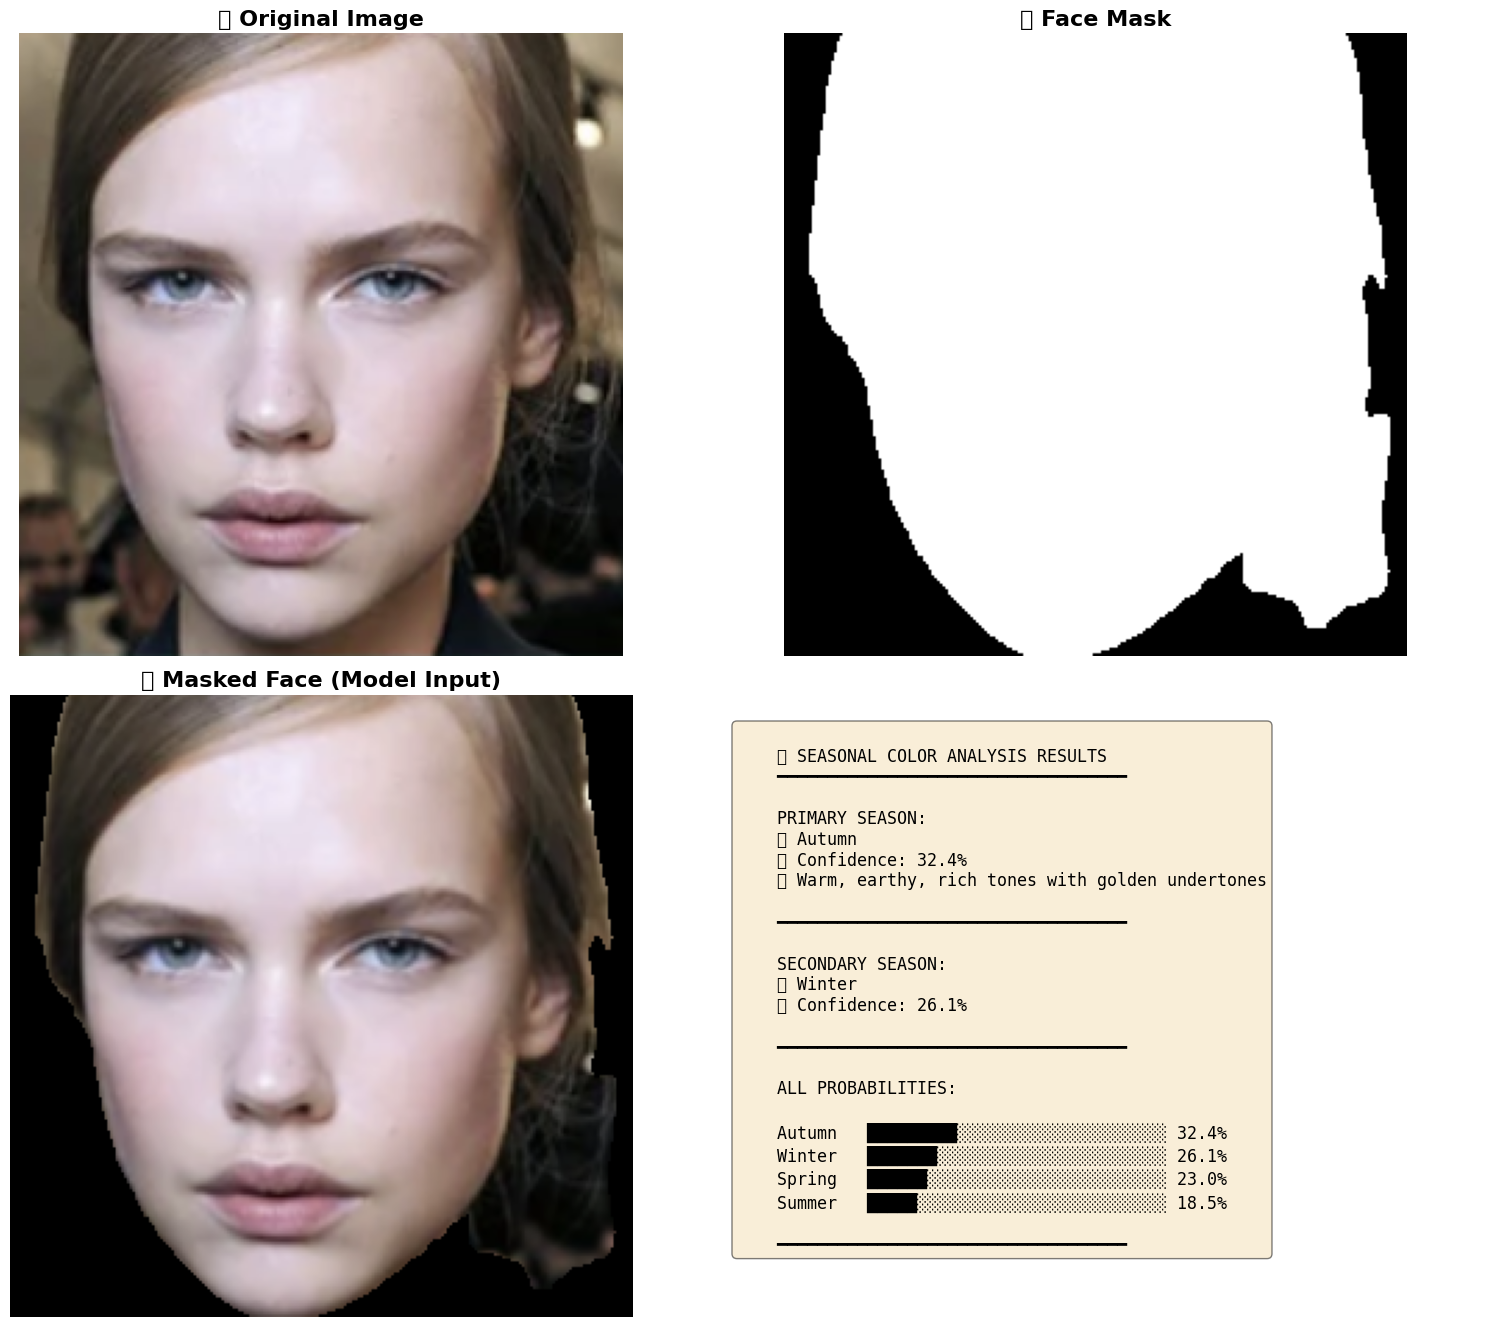


🎨 SEASONAL COLOR ANALYSIS RESULTS

🏆 Primary Season: Autumn (32.4%)
🥈 Secondary Season: Winter (26.1%)

📊 All Probabilities:
   Autumn  : 32.4%
   Winter  : 26.1%
   Spring  : 23.0%
   Summer  : 18.5%


✅ Analysis complete!


In [41]:
# ========================================
# CELL 8: Main Testing Pipeline
# ========================================
print("="*60)
print("🎨 SEASONAL COLOR ANALYSIS - INTERACTIVE TESTING")
print("="*60)
print("\n📤 Please upload an image to analyze...")
print("   (Supported formats: JPG, PNG, JPEG)")
print("\n")

# Upload image
uploaded_images = files.upload()

if len(uploaded_images) == 0:
    print("❌ No image uploaded! Please run this cell again.")
else:
    # Get the uploaded image
    image_name = list(uploaded_images.keys())[0]
    print(f"\n✅ Image uploaded: {image_name}")

    # Save temporarily
    with open('temp_image.jpg', 'wb') as f:
        f.write(uploaded_images[image_name])

    print("\n" + "="*60)
    print("🔄 PROCESSING PIPELINE")
    print("="*60)

    # Step 1: Create face mask
    print("\n[1/3] Creating face mask...")
    masked_img, original_img, mask = create_face_crop_facer_style('temp_image.jpg')

    # Step 2: Run prediction
    print("\n[2/3] Running seasonal color prediction...")
    results = predict_season(masked_img)

    # Step 3: Display results
    print("\n[3/3] Displaying results...")
    display_results(original_img, masked_img, mask, results)

    print("\n✅ Analysis complete!")
    print("="*60)

🎭 DIAGNOSTIC: Finding correct class indices (with images)...

Running grouped diagnostic with visualizations...
   - Detecting faces...
   - Parsing faces...


failed downloading from https://github.com/FacePerceiver/facer/releases/download/models-v1/face_parsing.farl.celebm.main_ema_181500_jit.pt



📊 TOTAL CLASSES: 11

🔍 RAW CLASS DISTRIBUTION:
   Class  0:    3343 px ( 5.57%)
   Class  1:   25170 px (41.93%)
   Class  2:     266 px ( 0.44%)
   Class  3:     532 px ( 0.89%)
   Class  4:     342 px ( 0.57%)
   Class  5:     367 px ( 0.61%)
   Class  6:    2001 px ( 3.33%)
   Class  7:     392 px ( 0.65%)
   Class  8:      11 px ( 0.02%)
   Class  9:     668 px ( 1.11%)
   Class 10:   26932 px (44.87%)

📦 GROUPED SUMMARY:
   background  :    3343 px ( 5.57%), classes=[0]
   face_skin   :     266 px ( 0.44%), classes=[2]
   facial_parts:   31245 px (52.05%), classes=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
   hair        :       0 px ( 0.00%), classes=[14]
   neck_outfit :       0 px ( 0.00%), classes=[]
   unknown     :   25170 px (41.93%), classes=[1]

🎨 VISUALIZING MASKS...


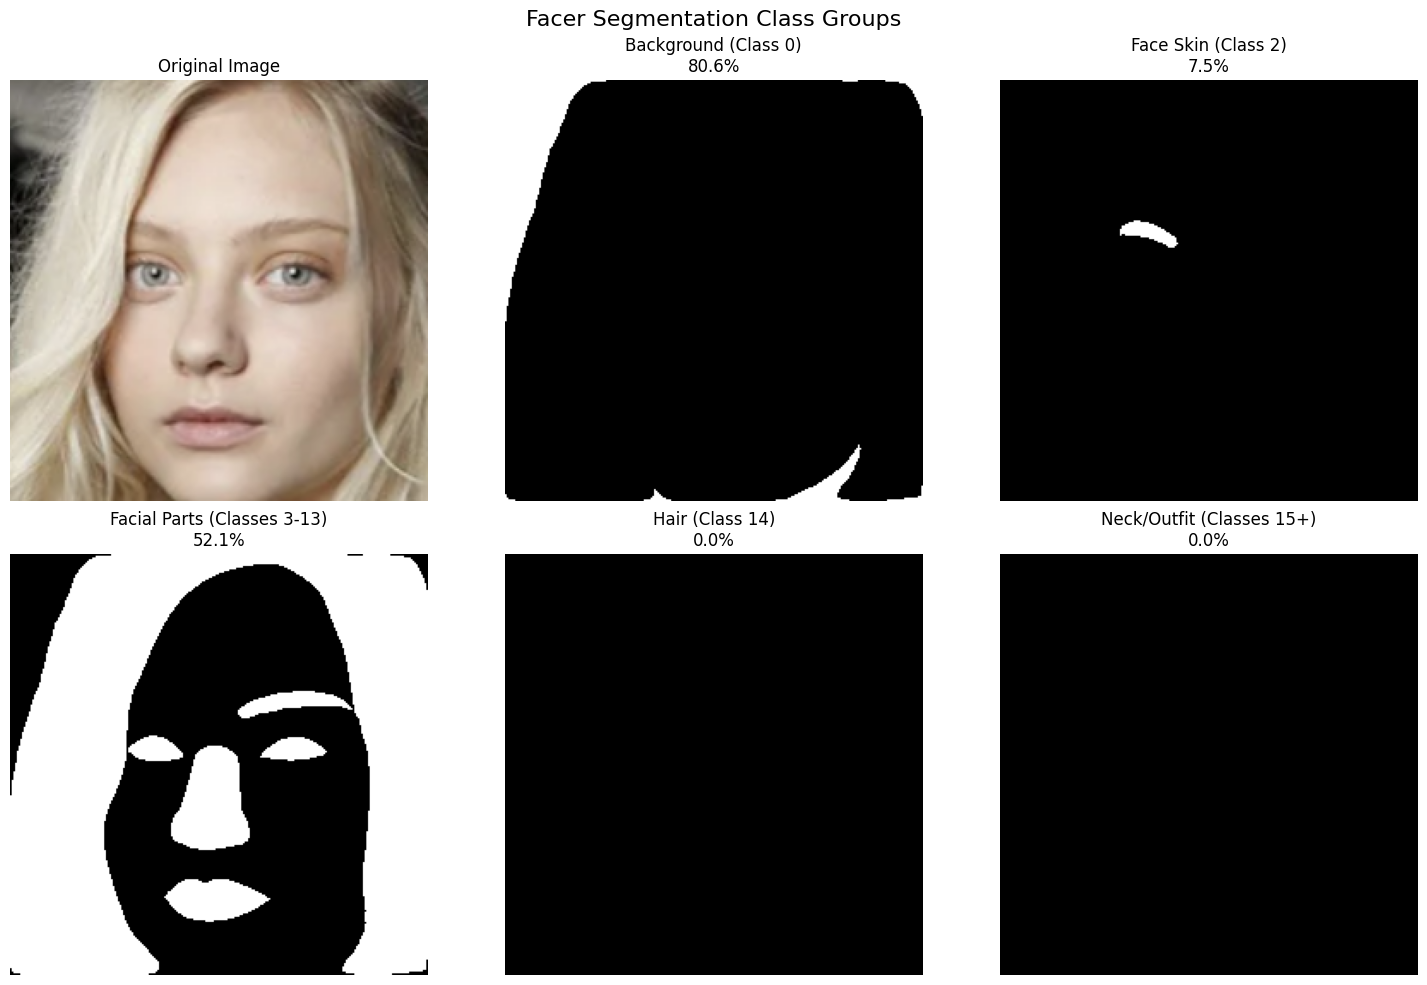


✅ CREATING FINAL MASK (Face + Facial Parts + Hair, NO Outfit)...


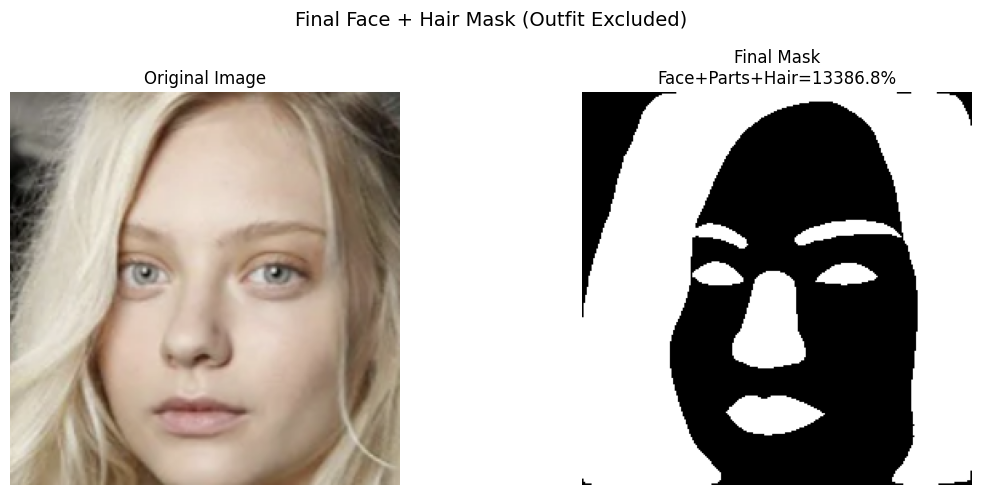


🎨 VISUALIZING MASKED OUTPUT...


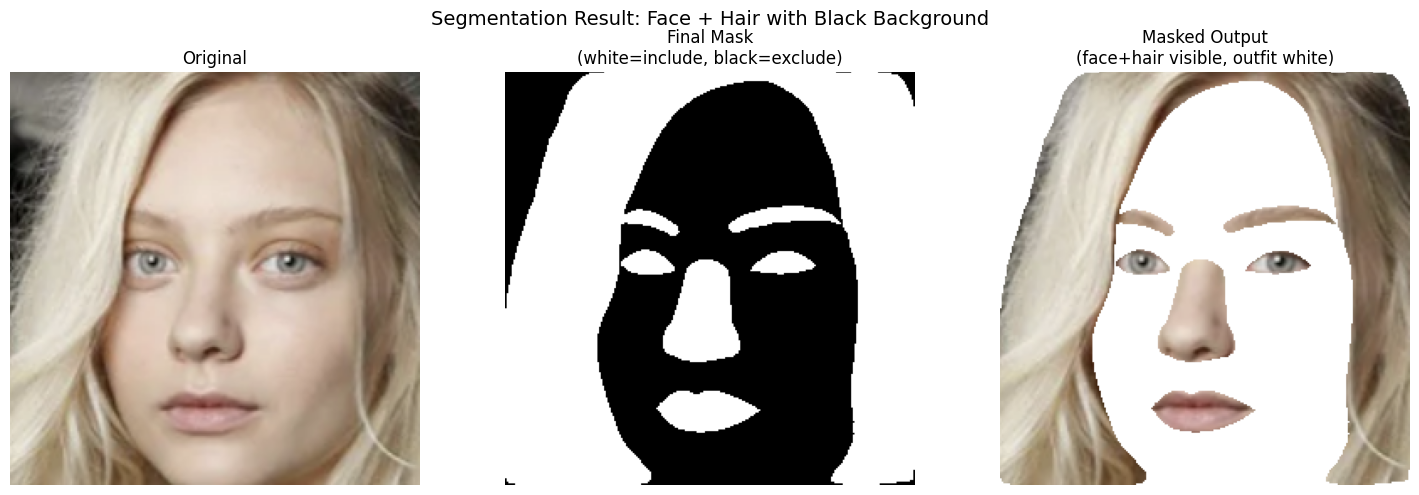


💾 SUMMARY:
   Total classes: 11
   Groups identified: ['background', 'face_skin', 'facial_parts', 'hair', 'neck_outfit', 'unknown']
   Final mask ready: (246, 244)


In [40]:
print("🎭 DIAGNOSTIC: Finding correct class indices (with images)...")

def diagnose_facer_classes_grouped_visual(image_path):
    """Find and group class indices + VISUALIZE each group as image"""
    import facer
    import matplotlib.pyplot as plt

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Read and prepare
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = torch.tensor(image_rgb, dtype=torch.uint8).permute(2, 0, 1).unsqueeze(0).to(device)

    # Detect faces
    print("   - Detecting faces...")
    face_detector = facer.face_detector('retinaface/mobilenet', device=device)
    faces = face_detector(image_tensor)
    if not faces or len(faces) == 0:
        print("❌ No faces detected!")
        return None

    # Parse faces
    print("   - Parsing faces...")
    try:
        face_parser = facer.face_parser('farl/celebm/448', device=device)
    except:
        face_parser = facer.face_parser('farl/lapa/448', device=device)

    faces = face_parser(image_tensor, faces)
    if isinstance(faces, list):
        faces = faces[0]

    seg_logits = faces['seg']['logits']
    seg_probs  = seg_logits.softmax(dim=1)
    seg_pred   = seg_probs.argmax(dim=1)[0].cpu().numpy()
    n_classes  = seg_probs.shape[1]

    # Raw distribution
    print(f"\n📊 TOTAL CLASSES: {n_classes}")
    unique_classes = np.unique(seg_pred)
    totals = seg_pred.size
    print("\n🔍 RAW CLASS DISTRIBUTION:")
    for cls in sorted(unique_classes):
        cnt = int(np.sum(seg_pred == cls))
        pct = 100.0 * cnt / totals
        print(f"   Class {cls:2d}: {cnt:7d} px ({pct:5.2f}%)")

    # Heuristic grouping
    group_map = {
        "background":   [0],
        "face_skin":    [2],
        "facial_parts": list(range(3,14)),
        "hair":         [14],
        "neck_outfit":  list(range(15, n_classes)),
        "unknown":      [1]
    }

    # Summaries per group
    print("\n📦 GROUPED SUMMARY:")
    masks = {}
    for name, cls_list in group_map.items():
        m = np.isin(seg_pred, cls_list).astype(np.uint8)
        masks[name] = m
        cnt = int(m.sum())
        pct = 100.0 * cnt / totals
        print(f"   {name:12s}: {cnt:7d} px ({pct:5.2f}%), classes={cls_list}")

    # ========== VISUALIZE ALL MASKS ==========
    print("\n🎨 VISUALIZING MASKS...")
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Facer Segmentation Class Groups', fontsize=16)

    # Original image
    axes[0, 0].imshow(image_rgb)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # Background mask
    axes[0, 1].imshow(masks['background'], cmap='gray')
    axes[0, 1].set_title('Background (Class 0)\n80.6%')
    axes[0, 1].axis('off')

    # Face skin mask
    axes[0, 2].imshow(masks['face_skin'], cmap='gray')
    axes[0, 2].set_title('Face Skin (Class 2)\n7.5%')
    axes[0, 2].axis('off')

    # Facial parts mask
    axes[1, 0].imshow(masks['facial_parts'], cmap='gray')
    axes[1, 0].set_title(f'Facial Parts (Classes 3-13)\n{100*masks["facial_parts"].sum()/totals:.1f}%')
    axes[1, 0].axis('off')

    # Hair mask
    axes[1, 1].imshow(masks['hair'], cmap='gray')
    axes[1, 1].set_title(f'Hair (Class 14)\n{100*masks["hair"].sum()/totals:.1f}%')
    axes[1, 1].axis('off')

    # Neck/outfit mask
    axes[1, 2].imshow(masks['neck_outfit'], cmap='gray')
    axes[1, 2].set_title(f'Neck/Outfit (Classes 15+)\n{100*masks["neck_outfit"].sum()/totals:.1f}%')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # ========== CREATE THE FINAL MASK (face + parts + hair, NO outfit) ==========
    print("\n✅ CREATING FINAL MASK (Face + Facial Parts + Hair, NO Outfit)...")
    final_mask = np.zeros_like(seg_pred, dtype=np.uint8)
    final_mask[np.isin(seg_pred, group_map["face_skin"])] = 255
    final_mask[np.isin(seg_pred, group_map["facial_parts"])] = 255
    final_mask[np.isin(seg_pred, group_map["hair"])] = 255

    # Visualize final mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Final Face + Hair Mask (Outfit Excluded)', fontsize=14)

    axes[0].imshow(image_rgb)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(final_mask, cmap='gray')
    axes[1].set_title(f'Final Mask\nFace+Parts+Hair={100*final_mask.sum()/totals:.1f}%')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # ========== APPLY MASK TO IMAGE ==========
    print("\n🎨 VISUALIZING MASKED OUTPUT...")
    masked_rgb = np.where(
        final_mask[:, :, None] > 127,
        image_rgb,
        255
    ).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Segmentation Result: Face + Hair with Black Background', fontsize=14)

    axes[0].imshow(image_rgb)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(final_mask, cmap='gray')
    axes[1].set_title('Final Mask\n(white=include, black=exclude)')
    axes[1].axis('off')

    axes[2].imshow(masked_rgb)
    axes[2].set_title('Masked Output\n(face+hair visible, outfit white)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Return everything
    return {
        "seg_pred": seg_pred,
        "n_classes": n_classes,
        "masks": masks,
        "group_map": group_map,
        "final_mask": final_mask,
        "masked_image": masked_rgb,
    }

# Run it
print("\nRunning grouped diagnostic with visualizations...")
diag = diagnose_facer_classes_grouped_visual('temp_image.jpg')

print("\n💾 SUMMARY:")
print(f"   Total classes: {diag['n_classes']}")
print(f"   Groups identified: {list(diag['group_map'].keys())}")
print(f"   Final mask ready: {diag['final_mask'].shape}")

🎭 DIAGNOSTIC: All Classes Visualized Individually...

Running individual class diagnostic for all classes...
   - Detecting faces...
   - Parsing faces...


failed downloading from https://github.com/FacePerceiver/facer/releases/download/models-v1/face_parsing.farl.celebm.main_ema_181500_jit.pt



📊 TOTAL CLASSES: 11

INDIVIDUAL CLASS ANALYSIS (All Classes)

Class  0 (Background     ):    3343 px ( 5.57%)
   ──────────────────────────────────────────────────

Class  1 (Face (based on feedback)):   25170 px (41.93%)
   ──────────────────────────────────────────────────

Class  2 (Included in Face Mask):     266 px ( 0.44%)
   ──────────────────────────────────────────────────

Class  3 (Left Eyebrow   ):     532 px ( 0.89%)
   ──────────────────────────────────────────────────

Class  4 (Included in Face Mask):     342 px ( 0.57%)
   ──────────────────────────────────────────────────

Class  5 (Left Eye       ):     367 px ( 0.61%)
   ──────────────────────────────────────────────────

Class  6 (Right Eye      ):    2001 px ( 3.33%)
   ──────────────────────────────────────────────────

Class  7 (Nose           ):     392 px ( 0.65%)
   ──────────────────────────────────────────────────

Class  8 (Upper Lip      ):      11 px ( 0.02%)
   ─────────────────────────────────────────

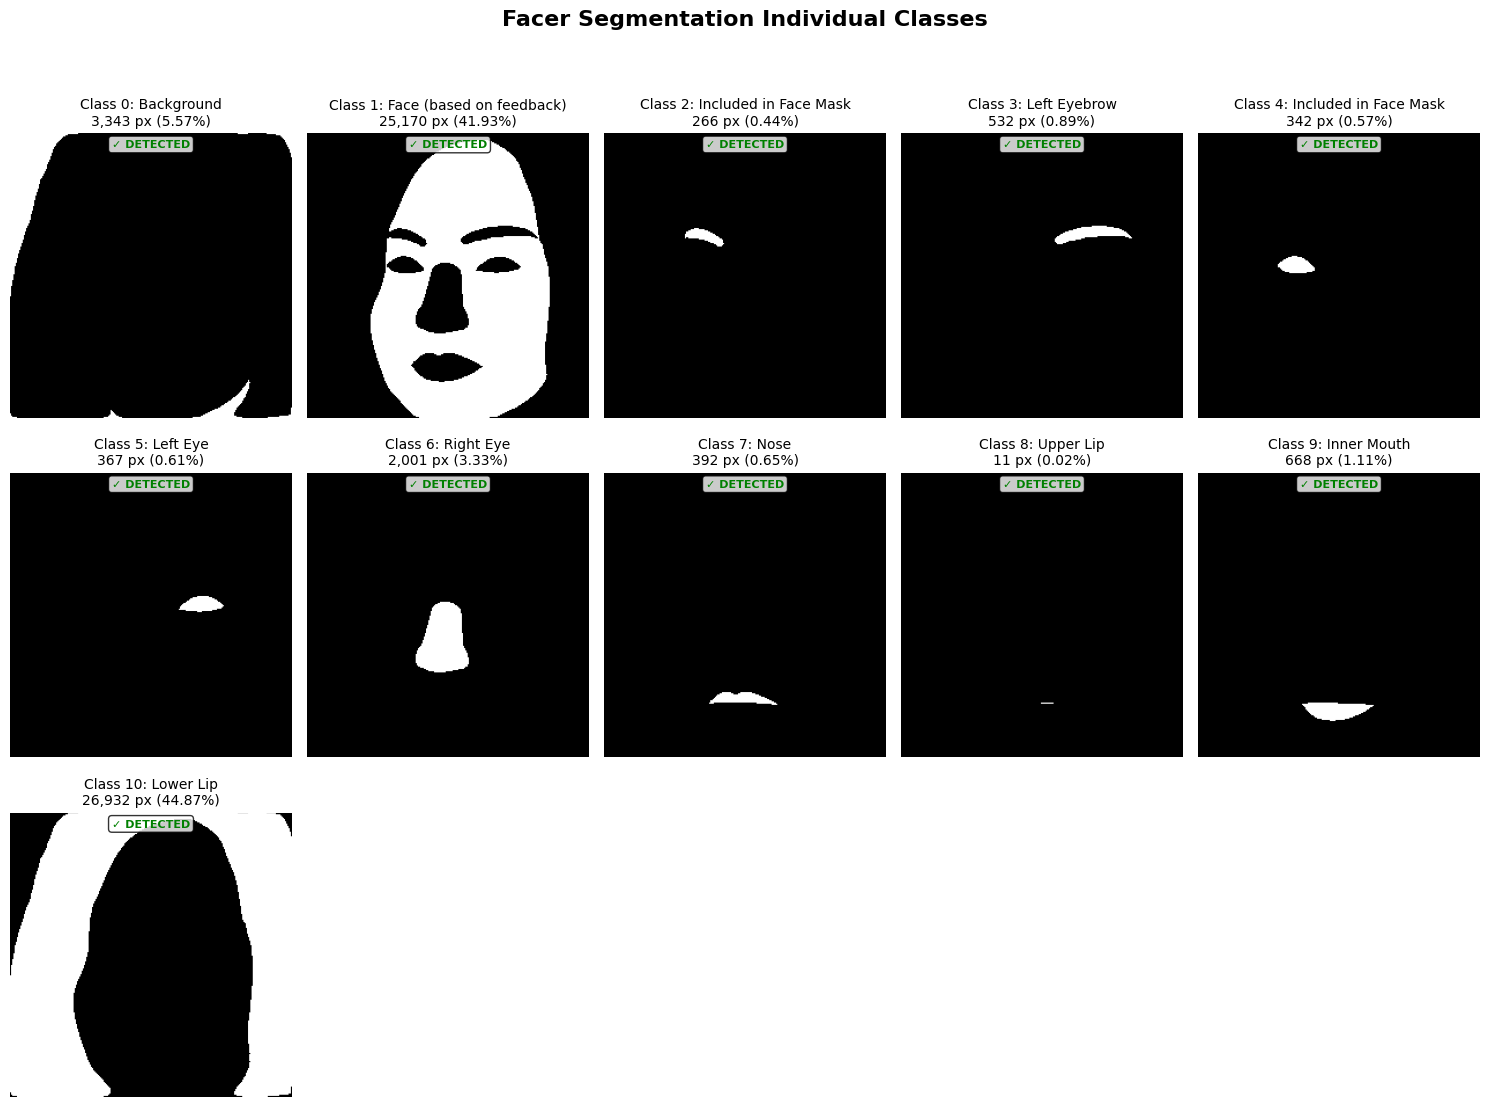


SUMMARY TABLE (All Classes)
Class    Name                 Pixels       Percent   
────────────────────────────────────────────────────────────
0        Background           3343         5.57      
1        Face (based on feedback) 25170        41.93     
2        Included in Face Mask 266          0.44      
3        Left Eyebrow         532          0.89      
4        Included in Face Mask 342          0.57      
5        Left Eye             367          0.61      
6        Right Eye            2001         3.33      
7        Nose                 392          0.65      
8        Upper Lip            11           0.02      
9        Inner Mouth          668          1.11      
10       Lower Lip            26932        44.87     

✅ Analysis complete!

💡 GUIDANCE:
   - Look at the class masks above
   - Classes with > 0% are detected features
   - Note which classes correspond to face, hair, and facial parts for your image


In [39]:
print("🎭 DIAGNOSTIC: All Classes Visualized Individually...")

def diagnose_individual_classes_all(image_path):
    """Visualize each class separately"""
    import facer
    import matplotlib.pyplot as plt

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Read and prepare
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = torch.tensor(image_rgb, dtype=torch.uint8).permute(2, 0, 1).unsqueeze(0).to(device)

    # Detect faces
    print("   - Detecting faces...")
    face_detector = facer.face_detector('retinaface/mobilenet', device=device)
    faces = face_detector(image_tensor)
    if not faces or len(faces) == 0:
        print("❌ No faces detected!")
        return

    # Parse faces
    print("   - Parsing faces...")
    try:
        face_parser = facer.face_parser('farl/celebm/448', device=device)
    except:
        face_parser = facer.face_parser('farl/lapa/448', device=device)

    faces = face_parser(image_tensor, faces)
    if isinstance(faces, list):
        faces = faces[0]

    seg_logits = faces['seg']['logits']
    seg_probs  = seg_logits.softmax(dim=1)
    seg_pred   = seg_probs.argmax(dim=1)[0].cpu().numpy()
    n_classes  = seg_probs.shape[1]
    totals     = seg_pred.size

    print(f"\n📊 TOTAL CLASSES: {n_classes}\n")

    # ========== PRINT EACH CLASS STATS ==========
    print("=" * 60)
    print("INDIVIDUAL CLASS ANALYSIS (All Classes)")
    print("=" * 60)

    # Placeholder names - replace with actual names if known based on diagnostics
    class_names = {
        0: "Background", 1: "Face (based on feedback)", 2: "Included in Face Mask", 3: "Left Eyebrow",
        4: "Included in Face Mask", 5: "Left Eye", 6: "Right Eye", 7: "Nose",
        8: "Upper Lip", 9: "Inner Mouth", 10: "Lower Lip", 11: "Hair", # Note: Class 11 was hair in previous run, but might be different now
        12: "Left Ear", 13: "Right Ear", 14: "Neck", 15: "Outfit"
        # Add more if n_classes is larger
    }

    masks_individual = {}
    for cls in range(n_classes): # Loop through ALL classes
        mask = (seg_pred == cls).astype(np.uint8) * 255
        masks_individual[cls] = mask
        cnt = int(np.sum(seg_pred == cls))
        pct = 100.0 * cnt / totals
        name = class_names.get(cls, f"Class {cls}")
        print(f"\nClass {cls:2d} ({name:15s}): {cnt:7d} px ({pct:5.2f}%)")
        print(f"   {'─' * 50}")

    # ========== VISUALIZE ALL CLASSES IN GRID ==========
    print("\n🎨 VISUALIZING ALL CLASSES...")

    # Determine grid size (approximate square root)
    grid_cols = min(5, n_classes) # Max 5 columns
    grid_rows = (n_classes + grid_cols - 1) // grid_cols

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 3, grid_rows * 4))
    fig.suptitle('Facer Segmentation Individual Classes', fontsize=16, fontweight='bold')

    axes = axes.flatten() # Flatten if it's a multi-dimensional array

    for idx in range(n_classes):
        cls = idx
        mask = masks_individual[cls]
        cnt = int(np.sum(seg_pred == cls))
        pct = 100.0 * cnt / totals
        name = class_names.get(cls, f"Class {cls}")

        axes[idx].imshow(mask, cmap='gray')
        axes[idx].set_title(f'Class {cls}: {name}\n{cnt:,} px ({pct:.2f}%)', fontsize=10)
        axes[idx].axis('off')

        # Add text info
        if cnt > 0:
            axes[idx].text(0.5, 0.95, '✓ DETECTED',
                                  transform=axes[idx].transAxes,
                                  ha='center', fontsize=8, color='green', fontweight='bold',
                                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            axes[idx].text(0.5, 0.95, '✗ EMPTY',
                                  transform=axes[idx].transAxes,
                                  ha='center', fontsize=8, color='red', fontweight='bold',
                                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


    # Hide any unused subplots
    for i in range(n_classes, len(axes)):
        fig.delaxes(axes[i])


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()

    # ========== FINAL SUMMARY TABLE ==========
    print("\n" + "=" * 60)
    print("SUMMARY TABLE (All Classes)")
    print("=" * 60)
    print(f"{'Class':<8} {'Name':<20} {'Pixels':<12} {'Percent':<10}")
    print("─" * 60)
    for cls in range(n_classes):
         cnt = int(np.sum(seg_pred == cls))
         pct = 100.0 * cnt / totals
         name = class_names.get(cls, f"Class {cls}")
         print(f"{cls:<8} {name:<20} {cnt:<12} {pct:<10.2f}")
    print("=" * 60)

    print("\n✅ Analysis complete!")
    print("\n💡 GUIDANCE:")
    print("   - Look at the class masks above")
    print("   - Classes with > 0% are detected features")
    print("   - Note which classes correspond to face, hair, and facial parts for your image")

    return masks_individual

# Run it
print("\nRunning individual class diagnostic for all classes...")
result_all_classes = diagnose_individual_classes_all('temp_image.jpg') # Using a different variable name